In [1]:
import re


from tensorflow.python.summary.summary_iterator import summary_iterator
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
import numpy as np

<ipython-input-1-ce82437b1779>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
EVENT_FILE_PATH = 'space_invaders.tfevents'
# EVENT_FILE_PATH = 'breakout.tfevents'

In [3]:
data = {}

for e in tqdm(summary_iterator(EVENT_FILE_PATH)):
    if len(e.summary.value) > 0:
        record = data.setdefault(e.summary.value[0].tag, {'x': [], 'y': []})
        record['x'].append(e.step)
        record['y'].append(e.summary.value[0].simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`



In [4]:
agents = []
for tag in data:
    match = re.match('ray/tune/evaluation/(.*)/episode_reward_mean', tag)
    if match is not None:
        agents.append(match.groups()[0])
agents = sorted(agents)

min_length = min(len(data[f'ray/tune/evaluation/{agent}/episode_reward_max']['y']) for agent in agents)

In [5]:
N_STEPS = 25000000
pos = np.searchsorted(data[f'ray/tune/evaluation/trainer/episode_reward_max']['x'], N_STEPS)

## Overall maximum until N_STEPS 

In [6]:
def get_max(agent):
    return max(data[f'ray/tune/evaluation/{agent}/episode_reward_max']['y'][:pos])


trainer_max = get_max('trainer')
for agent in agents:
    agent_max = get_max(agent)
    print(f'{agent:35s} {agent_max:5.0f}   {agent_max / trainer_max * 100:3.2f}%')

student_16_16_16_128_forward         1135   118.85%
student_16_16_16_128_no_q_loss        800   83.77%
student_16_16_16_128_reverse          800   83.77%
student_16_16_16_64_forward           865   90.58%
student_16_16_16_64_no_q_loss         970   101.57%
student_16_16_16_64_reverse           835   87.43%
student_16_32_32_256_forward         1000   104.71%
student_16_32_32_256_no_q_loss        805   84.29%
student_16_32_32_256_reverse          835   87.43%
trainer                               955   100.00%


## Mean in 10 epochs until N_STEPS

In [7]:
def get_mean(agent):
    return np.mean(data[f'ray/tune/evaluation/{agent}/episode_reward_mean']['y'][pos - 10 : pos])

trainer_mean = get_mean('trainer')
for agent in agents:
    agent_mean = get_mean(agent)
    print(f'{agent:35s} {agent_mean:5.0f}   {agent_mean / trainer_mean * 100:3.2f}%')

student_16_16_16_128_forward          488   124.31%
student_16_16_16_128_no_q_loss        504   128.17%
student_16_16_16_128_reverse          358   91.04%
student_16_16_16_64_forward           404   102.79%
student_16_16_16_64_no_q_loss         438   111.44%
student_16_16_16_64_reverse           401   102.07%
student_16_32_32_256_forward          332   84.47%
student_16_32_32_256_no_q_loss        378   96.15%
student_16_32_32_256_reverse          425   108.09%
trainer                               393   100.00%


# Overall training progression

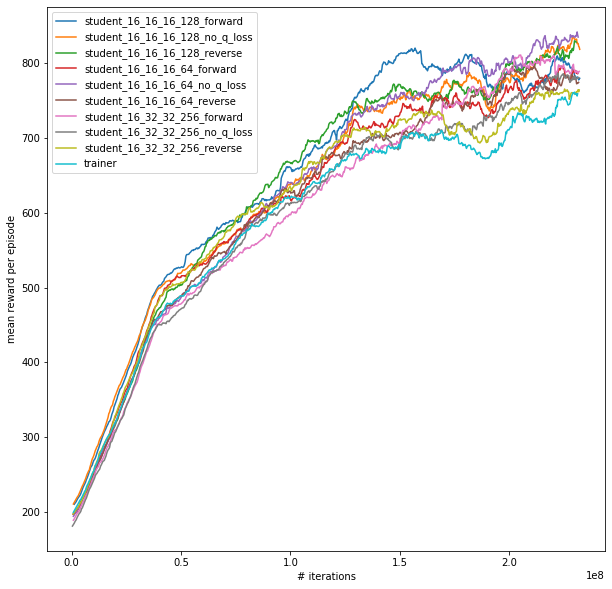

In [8]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


plt.figure(figsize=(10, 10))
for agent in sorted(agents):
    values = data[f'ray/tune/evaluation/{agent}/episode_reward_mean']
    plt.plot(values['x'][:-100], smooth(values['y'], 200)[:-100], label=agent)
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('mean reward per episode')
plt.show()

## Cumulative progression plots with respect to trainer cumulative maximum

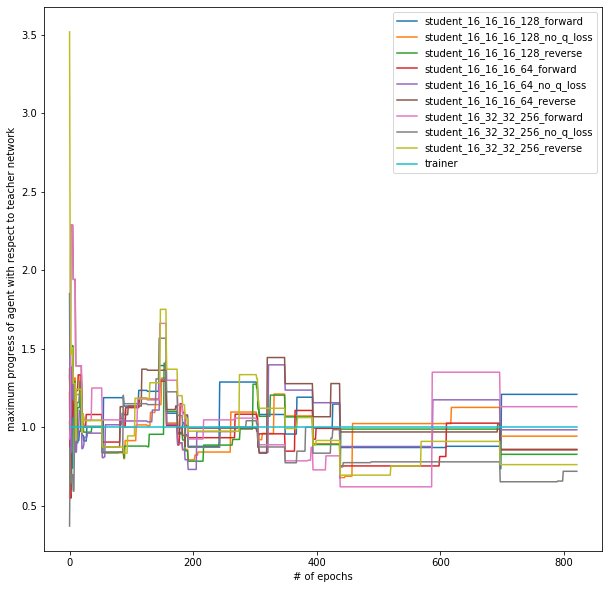

In [9]:
trainer_cum_max = np.maximum.accumulate(data[f'ray/tune/evaluation/trainer/episode_reward_max']['y'])[:min_length]

plt.figure(figsize=(10, 10))
for agent in agents:
    agents_mean = np.maximum.accumulate(data[f'ray/tune/evaluation/{agent}/episode_reward_max']['y'][:min_length])
    percents = agents_mean / trainer_cum_max
    plt.plot(percents, label=agent)
plt.legend()
plt.xlabel('# of epochs')
plt.ylabel('maximum progress of agent with respect to teacher network')
plt.show()